In [3]:
##   FD002+FD004

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:

# ---------- STEP 1: Load and Combine FD002 + FD004 ----------
def load_cmaps_data(file_path):
    df = pd.read_csv(file_path, sep=" ", header=None)
    df.drop([26, 27], axis=1, inplace=True)  # remove empty columns
    df.columns = ["unit", "time", "op1", "op2", "op3"] + [f"sensor_{i}" for i in range(1, 22)]
    return df

df2 = load_cmaps_data("/content/train_FD002.txt")
df4 = load_cmaps_data("/content/train_FD004.txt")

df2["source"] = "FD002"
df4["source"] = "FD004"

df = pd.concat([df2, df4], ignore_index=True)
df

,unit,time,op1,op2,op3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,FD002
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,FD002
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,FD002
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,FD002
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,FD002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115003,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,2388.73,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234,FD004
115004,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,2388.46,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151,FD004
115005,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,2388.48,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270,FD004
115006,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,2388.83,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774,FD004


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalize op1, op2, op3
scaler = StandardScaler()
op_features = scaler.fit_transform(df[['op1', 'op2', 'op3']])

# KMeans clustering of operating conditions
kmeans = KMeans(n_clusters=6, random_state=42)
df['op_cluster'] = kmeans.fit_predict(op_features)


In [6]:
# -------------------------------
# Normalize Sensor Readings Per Operating Cluster (NOT per unit)
# -------------------------------
sensor_cols = [col for col in df.columns if col.startswith("sensor_")]

# Normalize each sensor within each op_cluster group
df[sensor_cols] = df.groupby('op_cluster')[sensor_cols].transform(
    lambda x: (x - x.mean()) / x.std()
)



In [7]:
selected_sensors = ["sensor_2", "sensor_3", "sensor_4", "sensor_7", "sensor_8", "sensor_9", "sensor_11", "sensor_12", "sensor_13", "sensor_15", "sensor_17", "sensor_20", "sensor_21"]
data = df[selected_sensors]


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)
df['cluster'] = cluster_labels
df


,unit,time,op1,op2,op3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source,op_cluster,cluster
0,1,1,34.9983,0.8400,100.0,0.001059,-0.739421,-1.143317,0.902705,-0.006803,...,0.608660,0.000000,0.022779,NaN,NaN,-1.004750,-1.413628,FD002,5,0
1,1,2,41.9982,0.8408,100.0,NaN,0.681586,-0.036722,-0.029844,0.000728,...,0.406484,0.000426,-0.501554,NaN,NaN,-1.700030,-1.393874,FD002,0,0
2,1,3,24.9988,0.6218,60.0,0.000000,1.353720,-0.856777,-0.132516,0.000896,...,0.099012,0.000000,1.384195,NaN,-0.014285,-1.688780,1.345002,FD002,2,0
3,1,4,42.0077,0.8416,100.0,NaN,-0.159022,0.093120,0.040220,0.000728,...,0.012540,0.000426,-1.138357,NaN,NaN,-0.137632,1.556515,FD002,0,1
4,1,5,25.0005,0.6203,60.0,0.000000,0.719617,-0.689025,-0.067543,0.000896,...,0.132522,0.000000,1.384195,NaN,-0.014285,-1.282905,-0.616760,FD002,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115003,249,251,9.9998,0.2500,100.0,-0.000924,1.041449,2.455120,0.661647,0.000000,...,-3.321670,0.015198,1.610720,NaN,NaN,2.916653,3.461469,FD004,1,3
115004,249,252,0.0028,0.0015,100.0,0.000000,1.631593,1.471351,2.079285,-0.001127,...,-3.574187,-0.001305,1.863256,NaN,NaN,2.028106,2.631691,FD004,4,3
115005,249,253,0.0029,0.0000,100.0,0.000000,2.137479,2.832051,2.476495,-0.001127,...,-3.024823,-0.001305,1.258739,NaN,NaN,3.727295,3.422846,FD004,4,3
115006,249,254,35.0046,0.8400,100.0,0.001059,0.200047,2.542064,2.228942,-0.006803,...,-4.213062,0.000000,1.962294,NaN,NaN,3.145575,2.131292,FD004,5,3


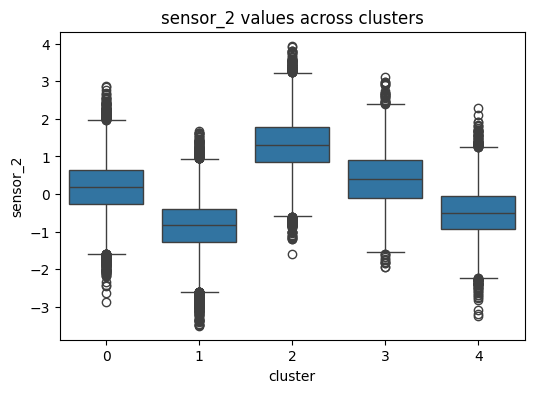

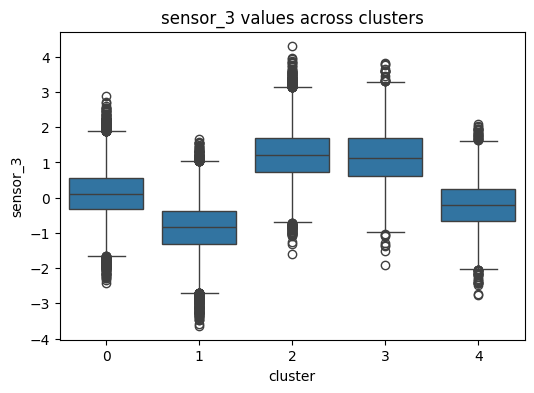

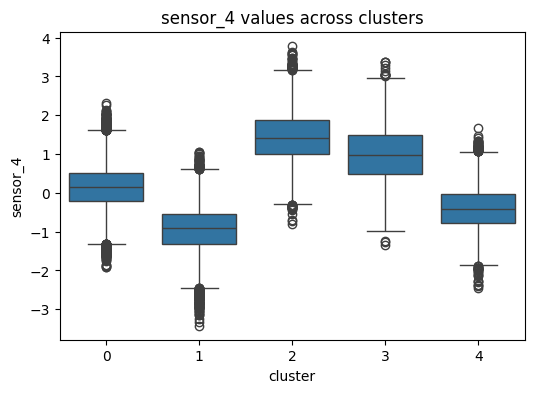

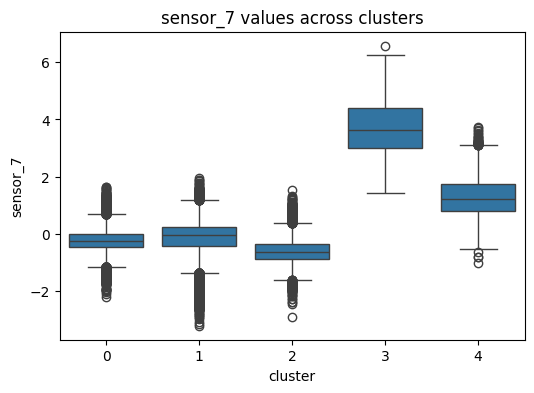

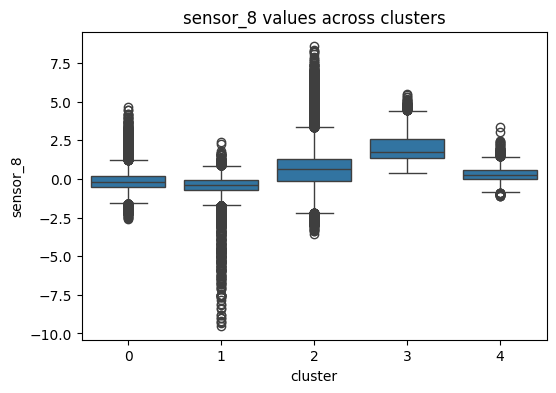

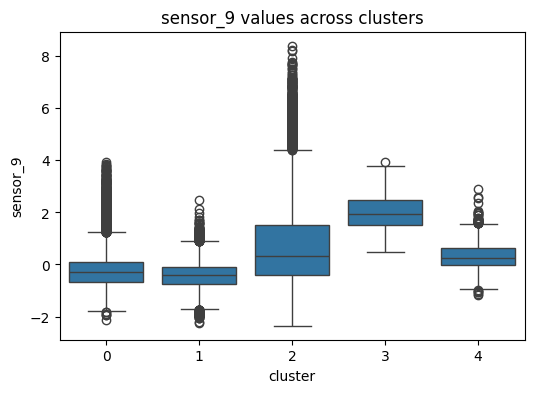

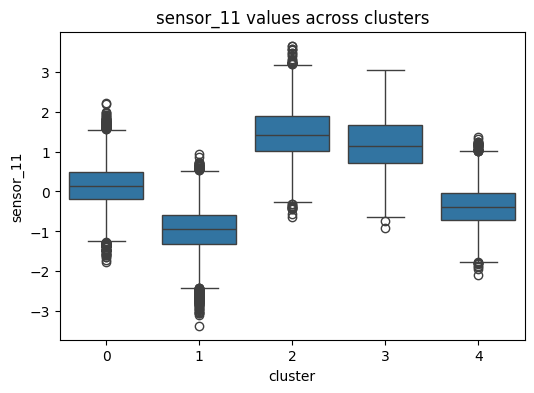

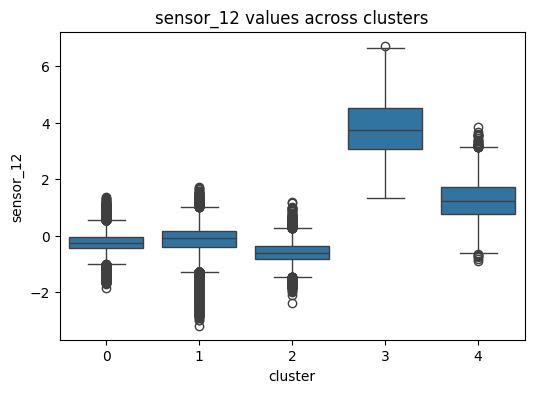

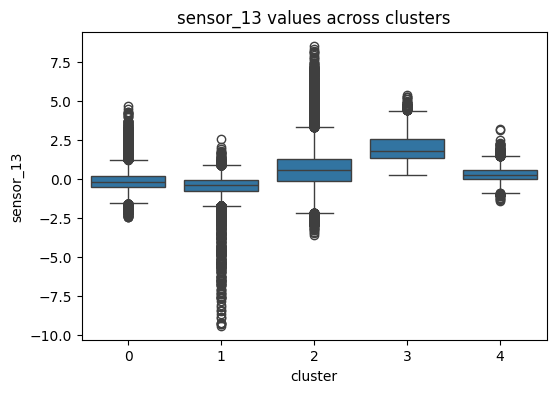

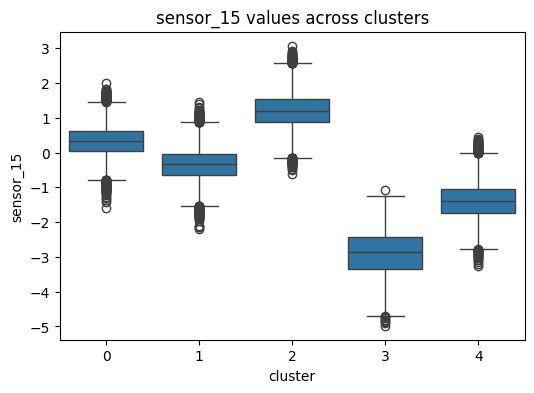

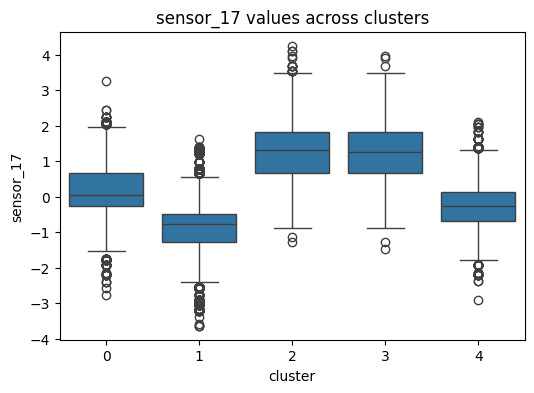

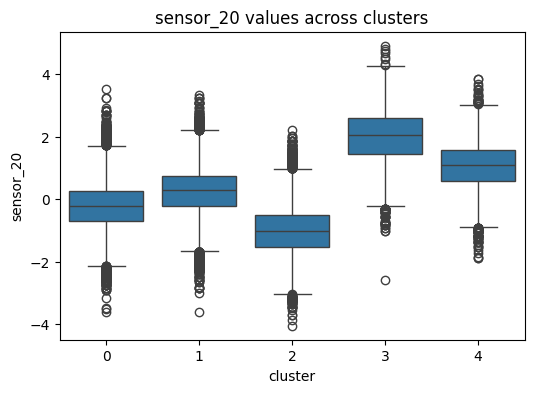

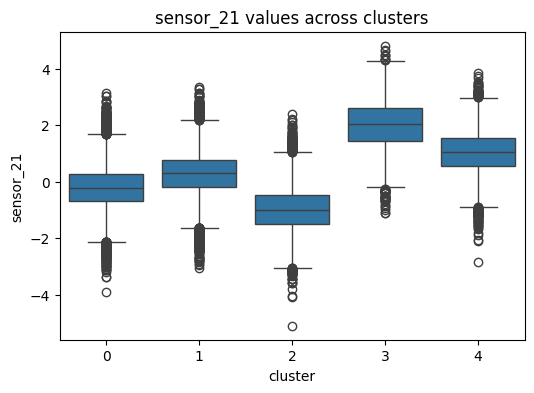

In [8]:

for sensor in selected_sensors:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='cluster', y=sensor)
    plt.title(f"{sensor} values across clusters")
    plt.show()


In [9]:
mapping = {
    0: 1,
    1: 0,
    2: 4,
    3: 3,
    4: 2
}
df['degradation_stage'] = df['cluster'].map(mapping)

df

,unit,time,op1,op2,op3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source,op_cluster,cluster,degradation_stage
0,1,1,34.9983,0.8400,100.0,0.001059,-0.739421,-1.143317,0.902705,-0.006803,...,0.000000,0.022779,NaN,NaN,-1.004750,-1.413628,FD002,5,0,1
1,1,2,41.9982,0.8408,100.0,NaN,0.681586,-0.036722,-0.029844,0.000728,...,0.000426,-0.501554,NaN,NaN,-1.700030,-1.393874,FD002,0,0,1
2,1,3,24.9988,0.6218,60.0,0.000000,1.353720,-0.856777,-0.132516,0.000896,...,0.000000,1.384195,NaN,-0.014285,-1.688780,1.345002,FD002,2,0,1
3,1,4,42.0077,0.8416,100.0,NaN,-0.159022,0.093120,0.040220,0.000728,...,0.000426,-1.138357,NaN,NaN,-0.137632,1.556515,FD002,0,1,0
4,1,5,25.0005,0.6203,60.0,0.000000,0.719617,-0.689025,-0.067543,0.000896,...,0.000000,1.384195,NaN,-0.014285,-1.282905,-0.616760,FD002,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115003,249,251,9.9998,0.2500,100.0,-0.000924,1.041449,2.455120,0.661647,0.000000,...,0.015198,1.610720,NaN,NaN,2.916653,3.461469,FD004,1,3,3
115004,249,252,0.0028,0.0015,100.0,0.000000,1.631593,1.471351,2.079285,-0.001127,...,-0.001305,1.863256,NaN,NaN,2.028106,2.631691,FD004,4,3,3
115005,249,253,0.0029,0.0000,100.0,0.000000,2.137479,2.832051,2.476495,-0.001127,...,-0.001305,1.258739,NaN,NaN,3.727295,3.422846,FD004,4,3,3
115006,249,254,35.0046,0.8400,100.0,0.001059,0.200047,2.542064,2.228942,-0.006803,...,0.000000,1.962294,NaN,NaN,3.145575,2.131292,FD004,5,3,3


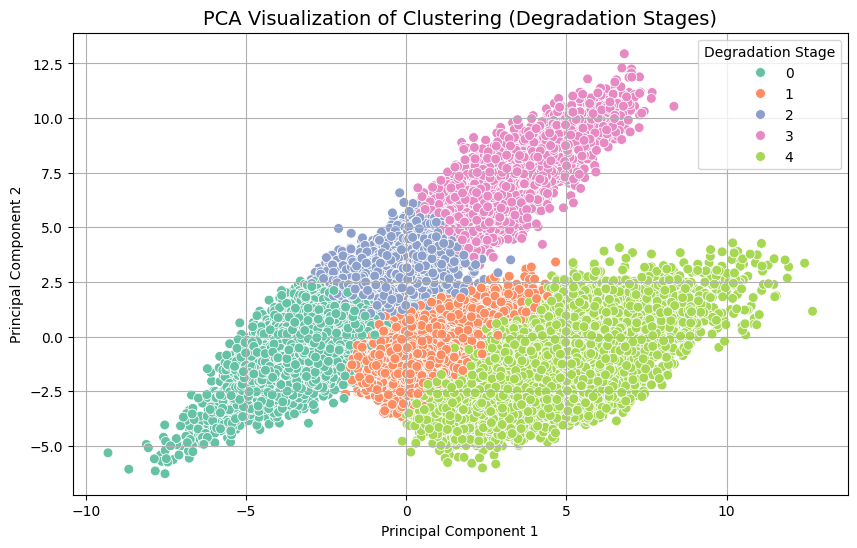

In [10]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce sensor data to 2D using PCA
pca = PCA(n_components=2)
sensor_data_2d = pca.fit_transform(df[selected_sensors])

# Create a DataFrame for plotting
plot_df = pd.DataFrame()
plot_df['PCA1'] = sensor_data_2d[:, 0]
plot_df['PCA2'] = sensor_data_2d[:, 1]
plot_df['Cluster'] = df['degradation_stage']  # or use df['cluster'] if not yet mapped
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=50)
plt.title('PCA Visualization of Clustering (Degradation Stages)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Degradation Stage')
plt.grid(True)
plt.show()


In [17]:
mapping = {
    0: 'Moderately Degraded',  # Moderately Degraded
    1: 'Normal',  # Normal
    2: 'Failure',  # Critical
    3: 'Slightly Degraded',  # Slightly Degraded
    4: 'Critical'   # Failure
}
df['degradation_stage'] = df['cluster'].map(mapping)
df.drop(columns=['cluster'], inplace=True)
df

,unit,time,op1,op2,op3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source,op_cluster,degradation_stage,time_to_next_stage
0,1,1,34.9983,0.8400,100.0,0.001059,-0.739421,-1.143317,0.902705,-0.006803,...,0.000000,0.022779,NaN,NaN,-1.004750,-1.413628,FD002,5,Moderately Degraded,109.0
1,1,1,42.0049,0.8400,100.0,NaN,0.207397,-1.606049,-1.530363,0.000728,...,0.000426,-0.501554,NaN,NaN,0.122768,0.062482,FD004,0,Normal,1.0
2,1,2,41.9982,0.8408,100.0,NaN,0.681586,-0.036722,-0.029844,0.000728,...,0.000426,-0.501554,NaN,NaN,-1.700030,-1.393874,FD002,0,Moderately Degraded,108.0
3,1,2,20.0020,0.7002,100.0,0.000974,-2.728417,-1.085597,-1.602364,0.000586,...,-0.478131,-2.544637,NaN,NaN,-0.780013,-0.447393,FD004,3,Normal,1.0
4,1,3,24.9988,0.6218,60.0,0.000000,1.353720,-0.856777,-0.132516,0.000896,...,0.000000,1.384195,NaN,-0.014285,-1.688780,1.345002,FD002,2,Moderately Degraded,107.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114950,260,259,42.0052,0.8412,100.0,NaN,-0.115914,0.607679,0.743186,0.000728,...,0.000426,0.135249,NaN,NaN,-0.398032,0.587060,FD002,0,Moderately Degraded,1.0
114953,260,262,42.0051,0.8400,100.0,NaN,0.897126,0.750346,0.621744,0.000728,...,0.000426,0.772052,NaN,NaN,0.903967,0.165369,FD002,0,Moderately Degraded,2.0
114954,260,263,42.0043,0.8400,100.0,NaN,0.272059,-0.251523,0.446586,0.000728,...,0.000426,0.772052,NaN,NaN,0.556767,1.107291,FD002,0,Moderately Degraded,1.0
114956,260,265,42.0048,0.8401,100.0,NaN,0.789356,-0.132902,0.496798,0.000728,...,0.000426,1.408855,NaN,NaN,1.337966,0.773995,FD002,0,Moderately Degraded,1.0


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7373
           1       0.95      0.98      0.96      9134
           2       0.95      0.89      0.92      1906
           3       0.99      0.97      0.98       842
           4       0.98      0.95      0.96      3747

    accuracy                           0.96     23002
   macro avg       0.97      0.95      0.96     23002
weighted avg       0.96      0.96      0.96     23002



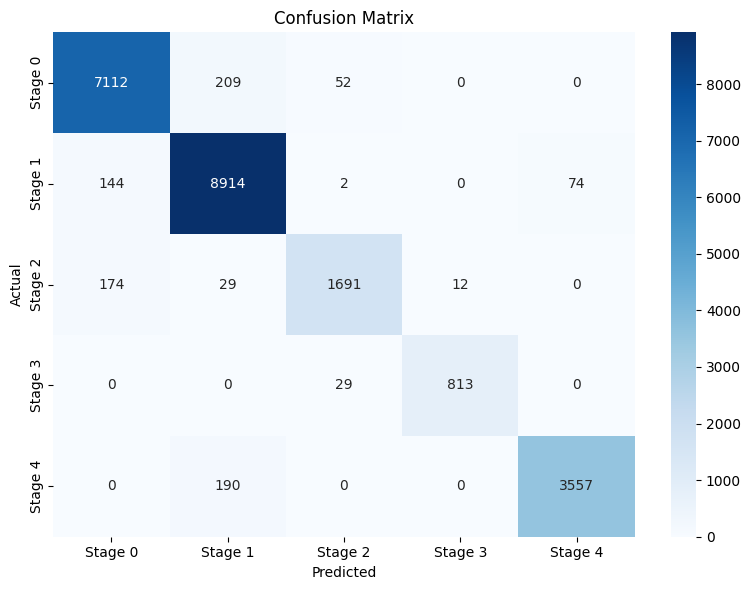

<ipython-input-11-1c2c820fd192>:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df, x="Importance", y="Sensor", palette="viridis")


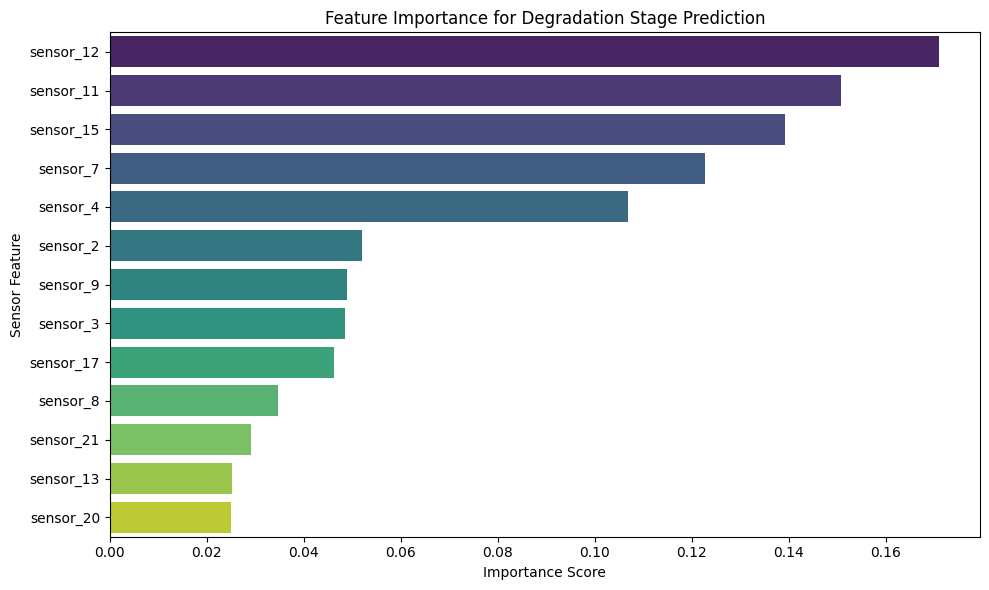

In [11]:

# Phase 2: Classification Model

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


#  Select features and target
sensor_cols = selected_sensors
X = df[sensor_cols]
y = df['degradation_stage']  # Target: 0–4 stages

#  Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Train/Test split (Stratify to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

#  Initialize and train the classifier
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)
clf.fit(X_train, y_train)

#  Predict on test set
y_pred = clf.predict(X_test)

#  Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Stage {i}' for i in range(5)],
            yticklabels=[f'Stage {i}' for i in range(5)])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

importances = clf.feature_importances_

# Create DataFrame
feature_df = pd.DataFrame({
    "Sensor": sensor_cols,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df, x="Importance", y="Sensor", palette="viridis")
plt.title("Feature Importance for Degradation Stage Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Sensor Feature")
plt.tight_layout()
plt.show()



In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
sensor_cols = selected_sensors
# Sort data per engine and cycle
df = df.sort_values(by=['unit', 'time']).reset_index(drop=True)

# Initialize target column
df["time_to_next_stage"] = np.nan

# Compute time to next degradation stage
for unit in df["unit"].unique():
    unit_df = df[df["unit"] == unit]
    for idx in unit_df.index:
        current_stage = df.loc[idx, "degradation_stage"]
        future = unit_df.loc[idx + 1:]
        # Find first row with a higher stage
        next_rows = future[future["degradation_stage"] > current_stage]
        if not next_rows.empty:
            time_left = next_rows.iloc[0]["time"] - df.loc[idx, "time"]
            df.loc[idx, "time_to_next_stage"] = time_left

# Drop rows with no label (already in final stage)
df = df.dropna(subset=["time_to_next_stage"])
df

,unit,time,op1,op2,op3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source,op_cluster,cluster,degradation_stage,time_to_next_stage
0,1,1,34.9983,0.8400,100.0,0.001059,-0.739421,-1.143317,0.902705,-0.006803,...,0.022779,NaN,NaN,-1.004750,-1.413628,FD002,5,0,1,109.0
1,1,1,42.0049,0.8400,100.0,NaN,0.207397,-1.606049,-1.530363,0.000728,...,-0.501554,NaN,NaN,0.122768,0.062482,FD004,0,1,0,1.0
2,1,2,41.9982,0.8408,100.0,NaN,0.681586,-0.036722,-0.029844,0.000728,...,-0.501554,NaN,NaN,-1.700030,-1.393874,FD002,0,0,1,108.0
3,1,2,20.0020,0.7002,100.0,0.000974,-2.728417,-1.085597,-1.602364,0.000586,...,-2.544637,NaN,NaN,-0.780013,-0.447393,FD004,3,1,0,1.0
4,1,3,24.9988,0.6218,60.0,0.000000,1.353720,-0.856777,-0.132516,0.000896,...,1.384195,NaN,-0.014285,-1.688780,1.345002,FD002,2,0,1,107.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114950,260,259,42.0052,0.8412,100.0,NaN,-0.115914,0.607679,0.743186,0.000728,...,0.135249,NaN,NaN,-0.398032,0.587060,FD002,0,0,1,1.0
114953,260,262,42.0051,0.8400,100.0,NaN,0.897126,0.750346,0.621744,0.000728,...,0.772052,NaN,NaN,0.903967,0.165369,FD002,0,0,1,2.0
114954,260,263,42.0043,0.8400,100.0,NaN,0.272059,-0.251523,0.446586,0.000728,...,0.772052,NaN,NaN,0.556767,1.107291,FD002,0,0,1,1.0
114956,260,265,42.0048,0.8401,100.0,NaN,0.789356,-0.132902,0.496798,0.000728,...,1.408855,NaN,NaN,1.337966,0.773995,FD002,0,0,1,1.0


Random Forest Regressor - MAE: 16.597249635981235, RMSE: 25.016220176072785, R²: 0.2119086826739247


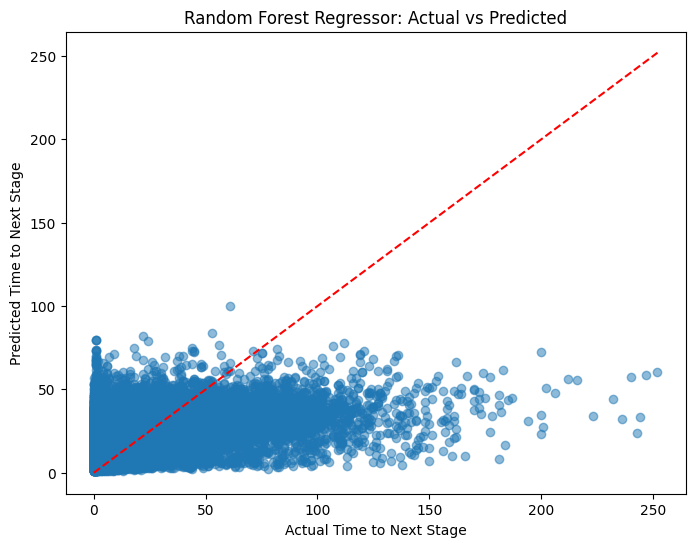

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define feature columns (sensor readings)
X = df[sensor_cols]
y = df['time_to_next_stage']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_regressor.predict(X_test)

# Evaluate the model using MAE, RMSE, and R²
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regressor - MAE: {mae_rf}, RMSE: {rmse_rf}, R²: {r2_rf}")

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel("Actual Time to Next Stage")
plt.ylabel("Predicted Time to Next Stage")
plt.title("Random Forest Regressor: Actual vs Predicted")
plt.show()


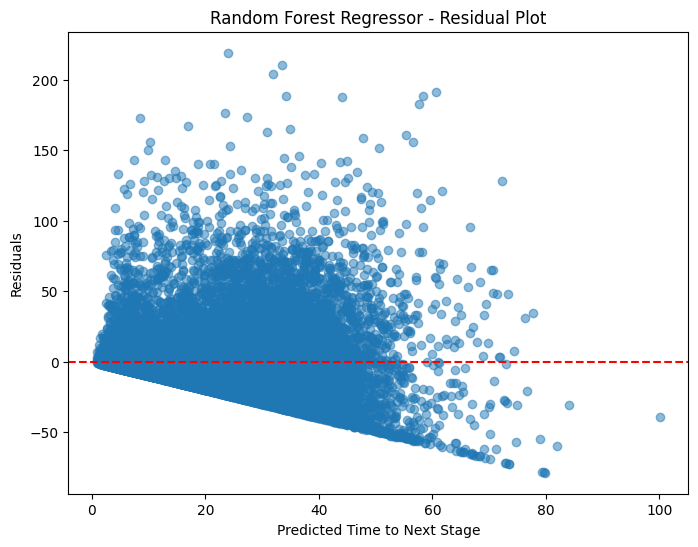

In [14]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Residual Plot for Random Forest
residual_rf = y_test - y_pred_rf
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf, residual_rf, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Time to Next Stage")
plt.ylabel("Residuals")
plt.title("Random Forest Regressor - Residual Plot")
plt.show()

['Critical' 'Moderately Degraded' 'Normal' 'Slightly Degraded']
⚠️ Maintenance Alert! Engine: 87, Time: 171, Risk Score: 0.722
⚠️ Maintenance Alert! Engine: 108, Time: 212, Risk Score: 0.758
⚠️ Maintenance Alert! Engine: 104, Time: 162, Risk Score: 0.875
⚠️ Maintenance Alert! Engine: 35, Time: 114, Risk Score: 0.706
⚠️ Maintenance Alert! Engine: 94, Time: 165, Risk Score: 0.815
⚠️ Maintenance Alert! Engine: 9, Time: 222, Risk Score: 0.737
⚠️ Maintenance Alert! Engine: 203, Time: 89, Risk Score: 0.753
⚠️ Maintenance Alert! Engine: 184, Time: 154, Risk Score: 0.734
⚠️ Maintenance Alert! Engine: 91, Time: 243, Risk Score: 0.925
⚠️ Maintenance Alert! Engine: 128, Time: 169, Risk Score: 0.737
⚠️ Maintenance Alert! Engine: 171, Time: 242, Risk Score: 0.884
⚠️ Maintenance Alert! Engine: 198, Time: 107, Risk Score: 0.709
⚠️ Maintenance Alert! Engine: 144, Time: 143, Risk Score: 0.753
⚠️ Maintenance Alert! Engine: 184, Time: 141, Risk Score: 0.848
⚠️ Maintenance Alert! Engine: 219, Time: 130, R

<ipython-input-21-46f5b5f3be02>:76: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


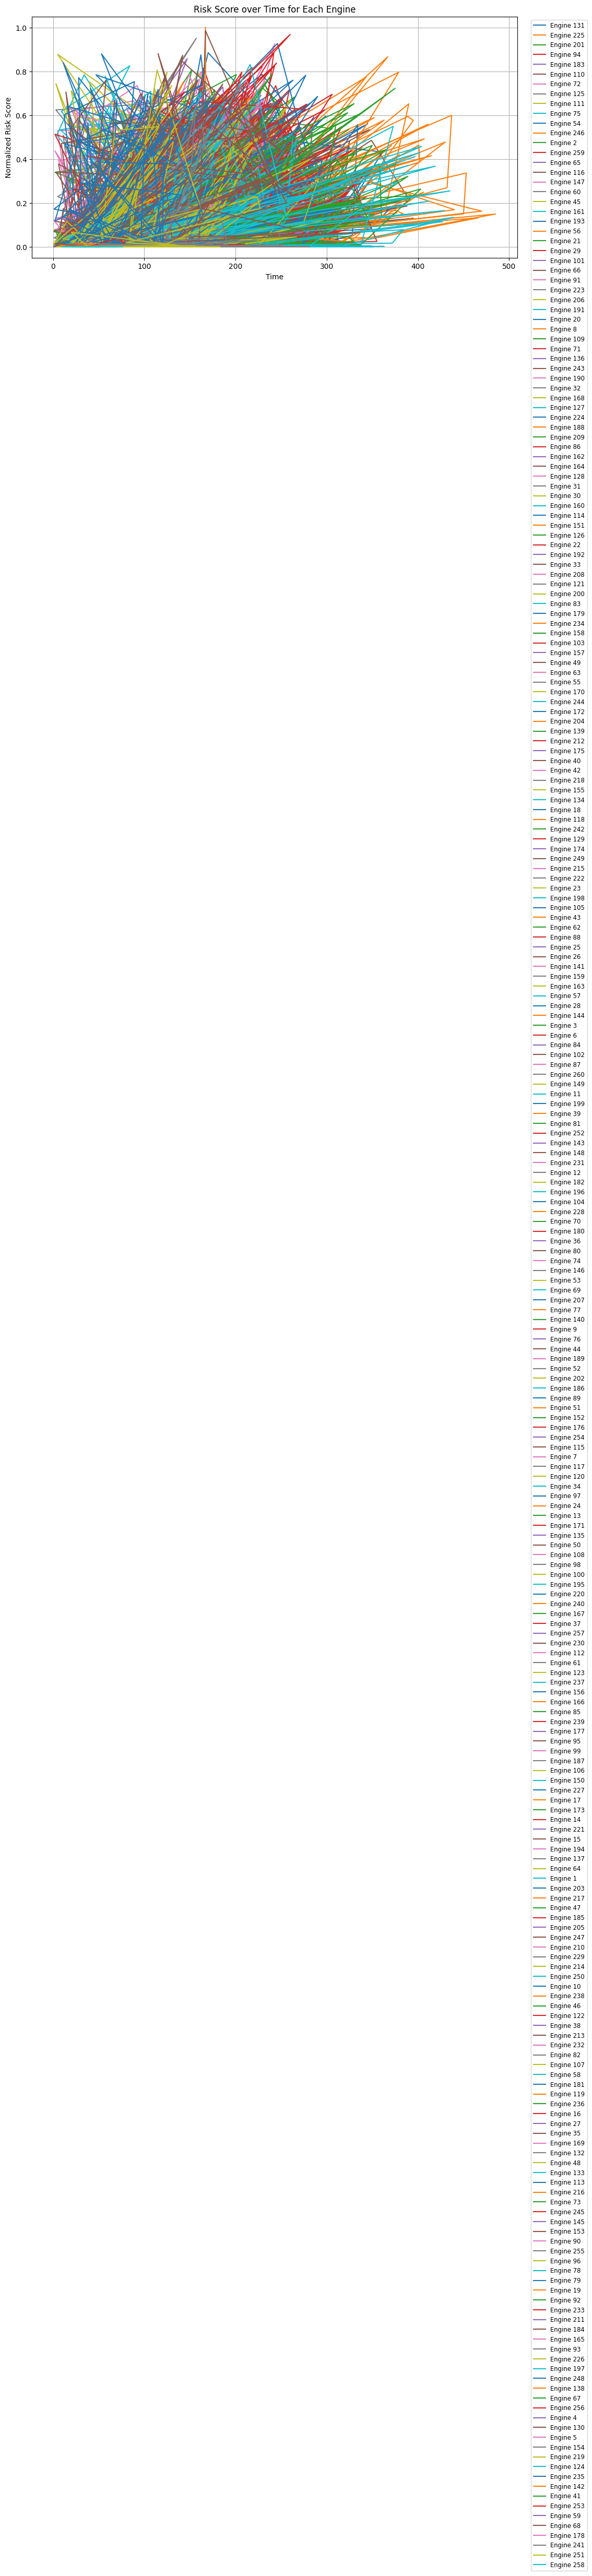

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

# Assume these are trained models
# clf -> Classifier (e.g., LogisticRegression, XGBoost, etc.)
# svr_regressor -> Regression model (e.g., SVR)
# X_test -> Test features
# df_test -> Original test dataframe containing 'unit', 'time', and 'degradation_stage' columns

# --- Predict failure probability (Stage 4 = "Failure") ---

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)


sensor_cols = ["sensor_2", "sensor_3", "sensor_4", "sensor_7", "sensor_8", "sensor_9", "sensor_11", "sensor_12", "sensor_13", "sensor_15", "sensor_17", "sensor_20", "sensor_21"]

X_train = df_train[sensor_cols].values
X_test = df_test[sensor_cols].values
X_test_df = pd.DataFrame(X_test, columns=sensor_cols)
X_train_df = pd.DataFrame(X_train, columns=sensor_cols)

y_train_class = df_train["degradation_stage"]
df_last = df_test.groupby("unit").last().reset_index()
# Confirm classifier is trained
print(clf.classes_)  # Check if "Failure" is present

# Make sure column match
assert list(X_test_df.columns) == list(X_train_df.columns)

#retraining
clf.fit(X_train_df, y_train_class)

# Predict failure probabilities
failure_index = list(clf.classes_).index("Critical")  # Only if "Failure" is a class
failure_probabilities = clf.predict_proba(X_test_df)[:, failure_index]

# --- Predict remaining useful life (time left to failure) ---
time_left = rf_regressor.predict(X_test)

# --- Compute Raw Risk Score ---
raw_risk_score = failure_probabilities * time_left

# --- Normalization 1: Min-Max ---
min_score = raw_risk_score.min()
max_score = raw_risk_score.max()
normalized_risk_score = (raw_risk_score - min_score) / (max_score - min_score + 1e-6)

# --- Normalization 2: Urgency-Based Inversion ---
urgency_risk_score = failure_probabilities / (time_left + 1e-6)


   # --- Set fixed threshold for issuing alerts ---
threshold = 0.7

# --- Issue maintenance alerts based on normalized risk score ---
for i in range(len(normalized_risk_score)):
    if normalized_risk_score[i] > threshold:
        unit = df_test.iloc[i]['unit'] if 'unit' in df_test.columns else f"Sample {i}"
        time = df_test.iloc[i]['time'] if 'time' in df_test.columns else "Unknown Time"
        print(f"⚠️ Maintenance Alert! Engine: {unit}, Time: {time}, Risk Score: {normalized_risk_score[i]:.3f}")

# --- Plot Risk Score Over Time for Each Engine ---
plt.figure(figsize=(12, 6))
for unit in df_test['unit'].unique():
    unit_mask = df_test['unit'] == unit
    plt.plot(df_test.loc[unit_mask, "time"], normalized_risk_score[unit_mask], label=f"Engine {unit}")

plt.xlabel("Time")
plt.ylabel("Normalized Risk Score")
plt.title("Risk Score over Time for Each Engine")
plt.grid(True)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1), ncol=1, fontsize="small")
plt.tight_layout()
plt.show()
